# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import spark libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import StringType, IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier #LinearSVC
from pyspark.ml.feature import StandardScaler, VectorAssembler, VectorIndexer, StringIndexer, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# import general libraries
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#set seaborn style
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 
sns.set_style('whitegrid')
#pd.set_option('float_format', '{:f}'.format)
sns.set()

In [3]:
# create a Spark session

spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# importing the dataset

path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
pd_df = pd.DataFrame(df.take(10), columns= df.columns)
pd_df

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
len(pd_df.columns)

18

In [7]:
df.count()

286500

---

### **Clean dataset**

In [5]:
def clean_data(df):
    """
    Cleaning the dataset:
    Remove special characters from string type variables, remove invalid users, format time variable and location.
    """
    
    def registered_days(df):
        """
        For each user calculates number of DAYS between registration to last interaction 
        """
        df_last_interaction =  df.groupBy('userId').agg(max('ts').alias('last_interaction'))

        df = df_last_interaction.join(df, on='userId').withColumn('registered_days', ((col('last_interaction')-col('registration'))/86400000).cast(IntegerType()))
        return df
    
    # cleanse stringtype fields from special characters
    for field in df.schema.fields:
        if field.dataType==StringType():
            df = df.withColumn(field.name, regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))
    # remove missing values in userId
    df = df.filter(df['userId']!='')
    df = df.filter(col('userId').isNotNull()) # not needed in this subset

    # Create a user defined function for formating the timestamp
    get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
    # Apply the udf on the ts column
    df = df.withColumn("time", get_time(df.ts))
    df = df.withColumn('month', month(col('time')))
    df = df.withColumn('day', dayofmonth(col('time')))
    df = df.withColumn('hour', hour(col('time')) )
    df = df.withColumn("input_timestamp",\
            to_timestamp(col("time"))) \
            .withColumn("day_of_year", date_format(col("input_timestamp"), "D"))
            
    
    # We want to keep only the state
    df = df.withColumn('state', split(col('location'),',').getItem(1))
    
    # apply function to obtain days since registration
    df = registered_days(df)
    
    return df

In [6]:
dfc = clean_data(df)

In [25]:
dfc.printSchema()

root
 |-- userId: string (nullable = true)
 |-- last_interaction: long (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- time: string (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- input_timestamp: timestamp (nullable = true)
 |-- day_of_year: string (nullable = true)
 |-- state: string (

Check that all the transformations are OK:

In [9]:
dfc.filter(dfc['userId']=='').count()
#df.filter( col('userId').isnotNull() ).count()

0

In [10]:
dfc.select( col("day"), col("month"), col("time"), col("ts")  ).show(10)

+---+-----+-------------------+-------------+
|day|month|               time|           ts|
+---+-----+-------------------+-------------+
| 21|   11|2018-11-21 18:12:32|1542823952000|
| 21|   11|2018-11-21 18:12:31|1542823951000|
| 21|   11|2018-11-21 18:08:02|1542823682000|
| 21|   11|2018-11-21 18:06:07|1542823567000|
| 21|   11|2018-11-21 18:00:57|1542823257000|
| 21|   11|2018-11-21 18:00:48|1542823248000|
| 21|   11|2018-11-21 17:55:46|1542822946000|
| 21|   11|2018-11-21 17:50:41|1542822641000|
| 21|   11|2018-11-21 17:47:14|1542822434000|
| 21|   11|2018-11-21 17:42:50|1542822170000|
+---+-----+-------------------+-------------+
only showing top 10 rows



In [11]:
dfc.withColumn("input_timestamp",\
    to_timestamp(col("time"))) \
    .withColumn("day_of_year", date_format(col("input_timestamp"), "D")) \
    .select("time", "day_of_year").limit(5).show()

+-------------------+-----------+
|               time|day_of_year|
+-------------------+-----------+
|2018-10-08 12:58:54|        281|
|2018-10-08 13:02:16|        281|
|2018-10-08 13:05:32|        281|
|2018-10-08 13:05:33|        281|
|2018-10-08 13:09:55|        281|
+-------------------+-----------+



In [12]:
dfc.select( col("location"), col("state") ).show(10)

+--------------------+-----+
|            location|state|
+--------------------+-----+
|Bridgeport-Stamfo...|   CT|
|Bridgeport-Stamfo...|   CT|
|Bridgeport-Stamfo...|   CT|
|Bridgeport-Stamfo...|   CT|
|Bridgeport-Stamfo...|   CT|
|Bridgeport-Stamfo...|   CT|
|Bridgeport-Stamfo...|   CT|
|Bridgeport-Stamfo...|   CT|
|Bridgeport-Stamfo...|   CT|
|Bridgeport-Stamfo...|   CT|
+--------------------+-----+
only showing top 10 rows



In [13]:
dfc.describe("registered_days").show()

+-------+------------------+
|summary|   registered_days|
+-------+------------------+
|  count|            278154|
|   mean| 88.54100606139045|
| stddev|40.447587528983775|
|    min|                 0|
|    max|               256|
+-------+------------------+



Now we can use SQL with the cleaned dataset to perform the data analysis

In [7]:
#Create a temporary view to perform SQL operations
dfc.createOrReplaceTempView("usersclean")

---

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [15]:
spark.sql("SELECT * FROM usersclean LIMIT 1").show()

+------+----------------+------------------+--------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+-----+---+----+-------------------+-----------+-----+---------------+
|userId|last_interaction|            artist|    auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|               time|month|day|hour|    input_timestamp|day_of_year|state|registered_days|
+------+----------------+------------------+--------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------------------+-----+---+----+-------------------+-----------+-----+---------------+
|100010|   1542823952000|Sle

In [16]:
spark.sql("SELECT max(time) FROM usersclean").show()

+-------------------+
|          max(time)|
+-------------------+
|2018-12-03 01:11:16|
+-------------------+



In [17]:
spark.sql("SELECT min(time) FROM usersclean").show()

+-------------------+
|          min(time)|
+-------------------+
|2018-10-01 00:01:57|
+-------------------+



In [18]:
spark.sql("""
          SELECT auth, COUNT(DISTINCT userId) as freq
          FROM usersclean
          Group BY auth
          """).show()

+---------+----+
|     auth|freq|
+---------+----+
|Cancelled|  52|
| LoggedIn| 225|
+---------+----+



In [19]:
spark.sql('''
        SELECT auth,COUNT(userId) AS user_counts
        FROM usersclean
        GROUP BY auth
''').show()


+---------+-----------+
|     auth|user_counts|
+---------+-----------+
|Cancelled|         52|
| LoggedIn|     278102|
+---------+-----------+



In [20]:
spark.sql("""
          SELECT userAgent, COUNT(DISTINCT userId) as freq
          FROM usersclean
          Group BY userAgent
          """).show()

+--------------------+----+
|           userAgent|freq|
+--------------------+----+
|Mozilla50compatib...|   1|
|Mozilla50WindowsN...|   1|
|Mozilla50compatib...|   3|
|Mozilla50Macintos...|   2|
|Mozilla50WindowsN...|   1|
|Mozilla50Macintos...|   2|
|Mozilla50compatib...|   1|
|Mozilla50WindowsN...|   2|
|Mozilla50Macintos...|   1|
|Mozilla50X11Ubunt...|   1|
|Mozilla50iPadCPUO...|   2|
|Mozilla50Macintos...|  10|
|Mozilla50WindowsN...|   7|
|Mozilla50Macintos...|   1|
|Mozilla50Macintos...|   1|
|Mozilla50WindowsN...|   1|
|Mozilla50WindowsN...|   4|
|Mozilla50Macintos...|   9|
|Mozilla50WindowsN...|   2|
|Mozilla50WindowsN...|   7|
+--------------------+----+
only showing top 20 rows



In [21]:
#spark.sql("""
#    select time
#    ,ROW_NUMBER() OVER (PARTITION BY userId, sessionId ORDER BY time DESC) as rowNum
#    from usersclean
#""")

In [22]:
df.describe("itemInSession").show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max|              1321|
+-------+------------------+



In [13]:
# could be slow with the big dataset
df_user_action = spark.sql('''
        SELECT userId, count(userId) as action_freq
        FROM usersclean
        Group BY userId
''').toPandas()

# seaborn needs to be updated to use histplot:
# sns.histplot(x='registered_days', y= "user_freq", data=df_days_registration, binwidth=7);

In [14]:
diff_users = spark.sql("""
          SELECT level, count(level) as freq
          FROM usersclean
          Group By level
          """)

In [18]:
diff_users.show()

+-----+------+
|level|  freq|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+



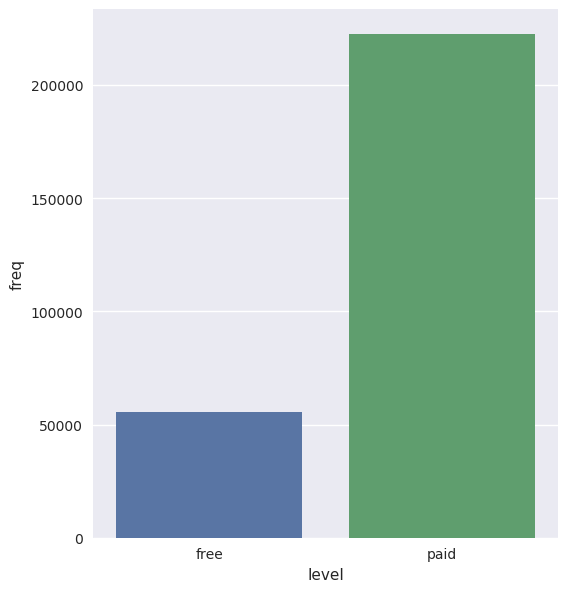

In [16]:
sns.set(font_scale = 1);
fig, ax = plt.subplots(figsize=(6,7));
sns.barplot(x='level',y='freq',data=diff_users.toPandas());

In [19]:
spark.sql('''
        SELECT level, COUNT(DISTINCT userId) AS user_freq
        FROM usersclean
        GROUP BY level
        ORDER BY user_freq DESC
''').show()

+-----+---------+
|level|user_freq|
+-----+---------+
| free|      195|
| paid|      165|
+-----+---------+



In [21]:
spark.sql('''
        SELECT COUNT(DISTINCT userId) AS user_freq
        FROM usersclean
''').show()

+---------+
|user_freq|
+---------+
|      225|
+---------+



In [39]:
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM usersclean
        GROUP BY gender
        ORDER BY user_counts DESC
''')
gender_count.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



In [40]:
spark.sql('''
        SELECT COUNT(DISTINCT page) AS categories_page
        FROM usersclean
''').show()

+---------------+
|categories_page|
+---------------+
|             19|
+---------------+



In [41]:
spark.sql('''
        SELECT page, COUNT(DISTINCT userId) AS user_freq
        FROM usersclean
        GROUP BY page
        ORDER BY user_freq DESC
''').show()

+--------------------+---------+
|                page|user_freq|
+--------------------+---------+
|            NextSong|      225|
|                Home|      223|
|            ThumbsUp|      220|
|       AddtoPlaylist|      215|
|              Logout|      213|
|          RollAdvert|      207|
|           AddFriend|      206|
|          ThumbsDown|      203|
|            Settings|      195|
|                Help|      192|
|             Upgrade|      168|
|               About|      155|
|           Downgrade|      154|
|        SaveSettings|      132|
|       SubmitUpgrade|      131|
|               Error|      117|
|CancellationConfi...|       52|
|              Cancel|       52|
|     SubmitDowngrade|       49|
+--------------------+---------+



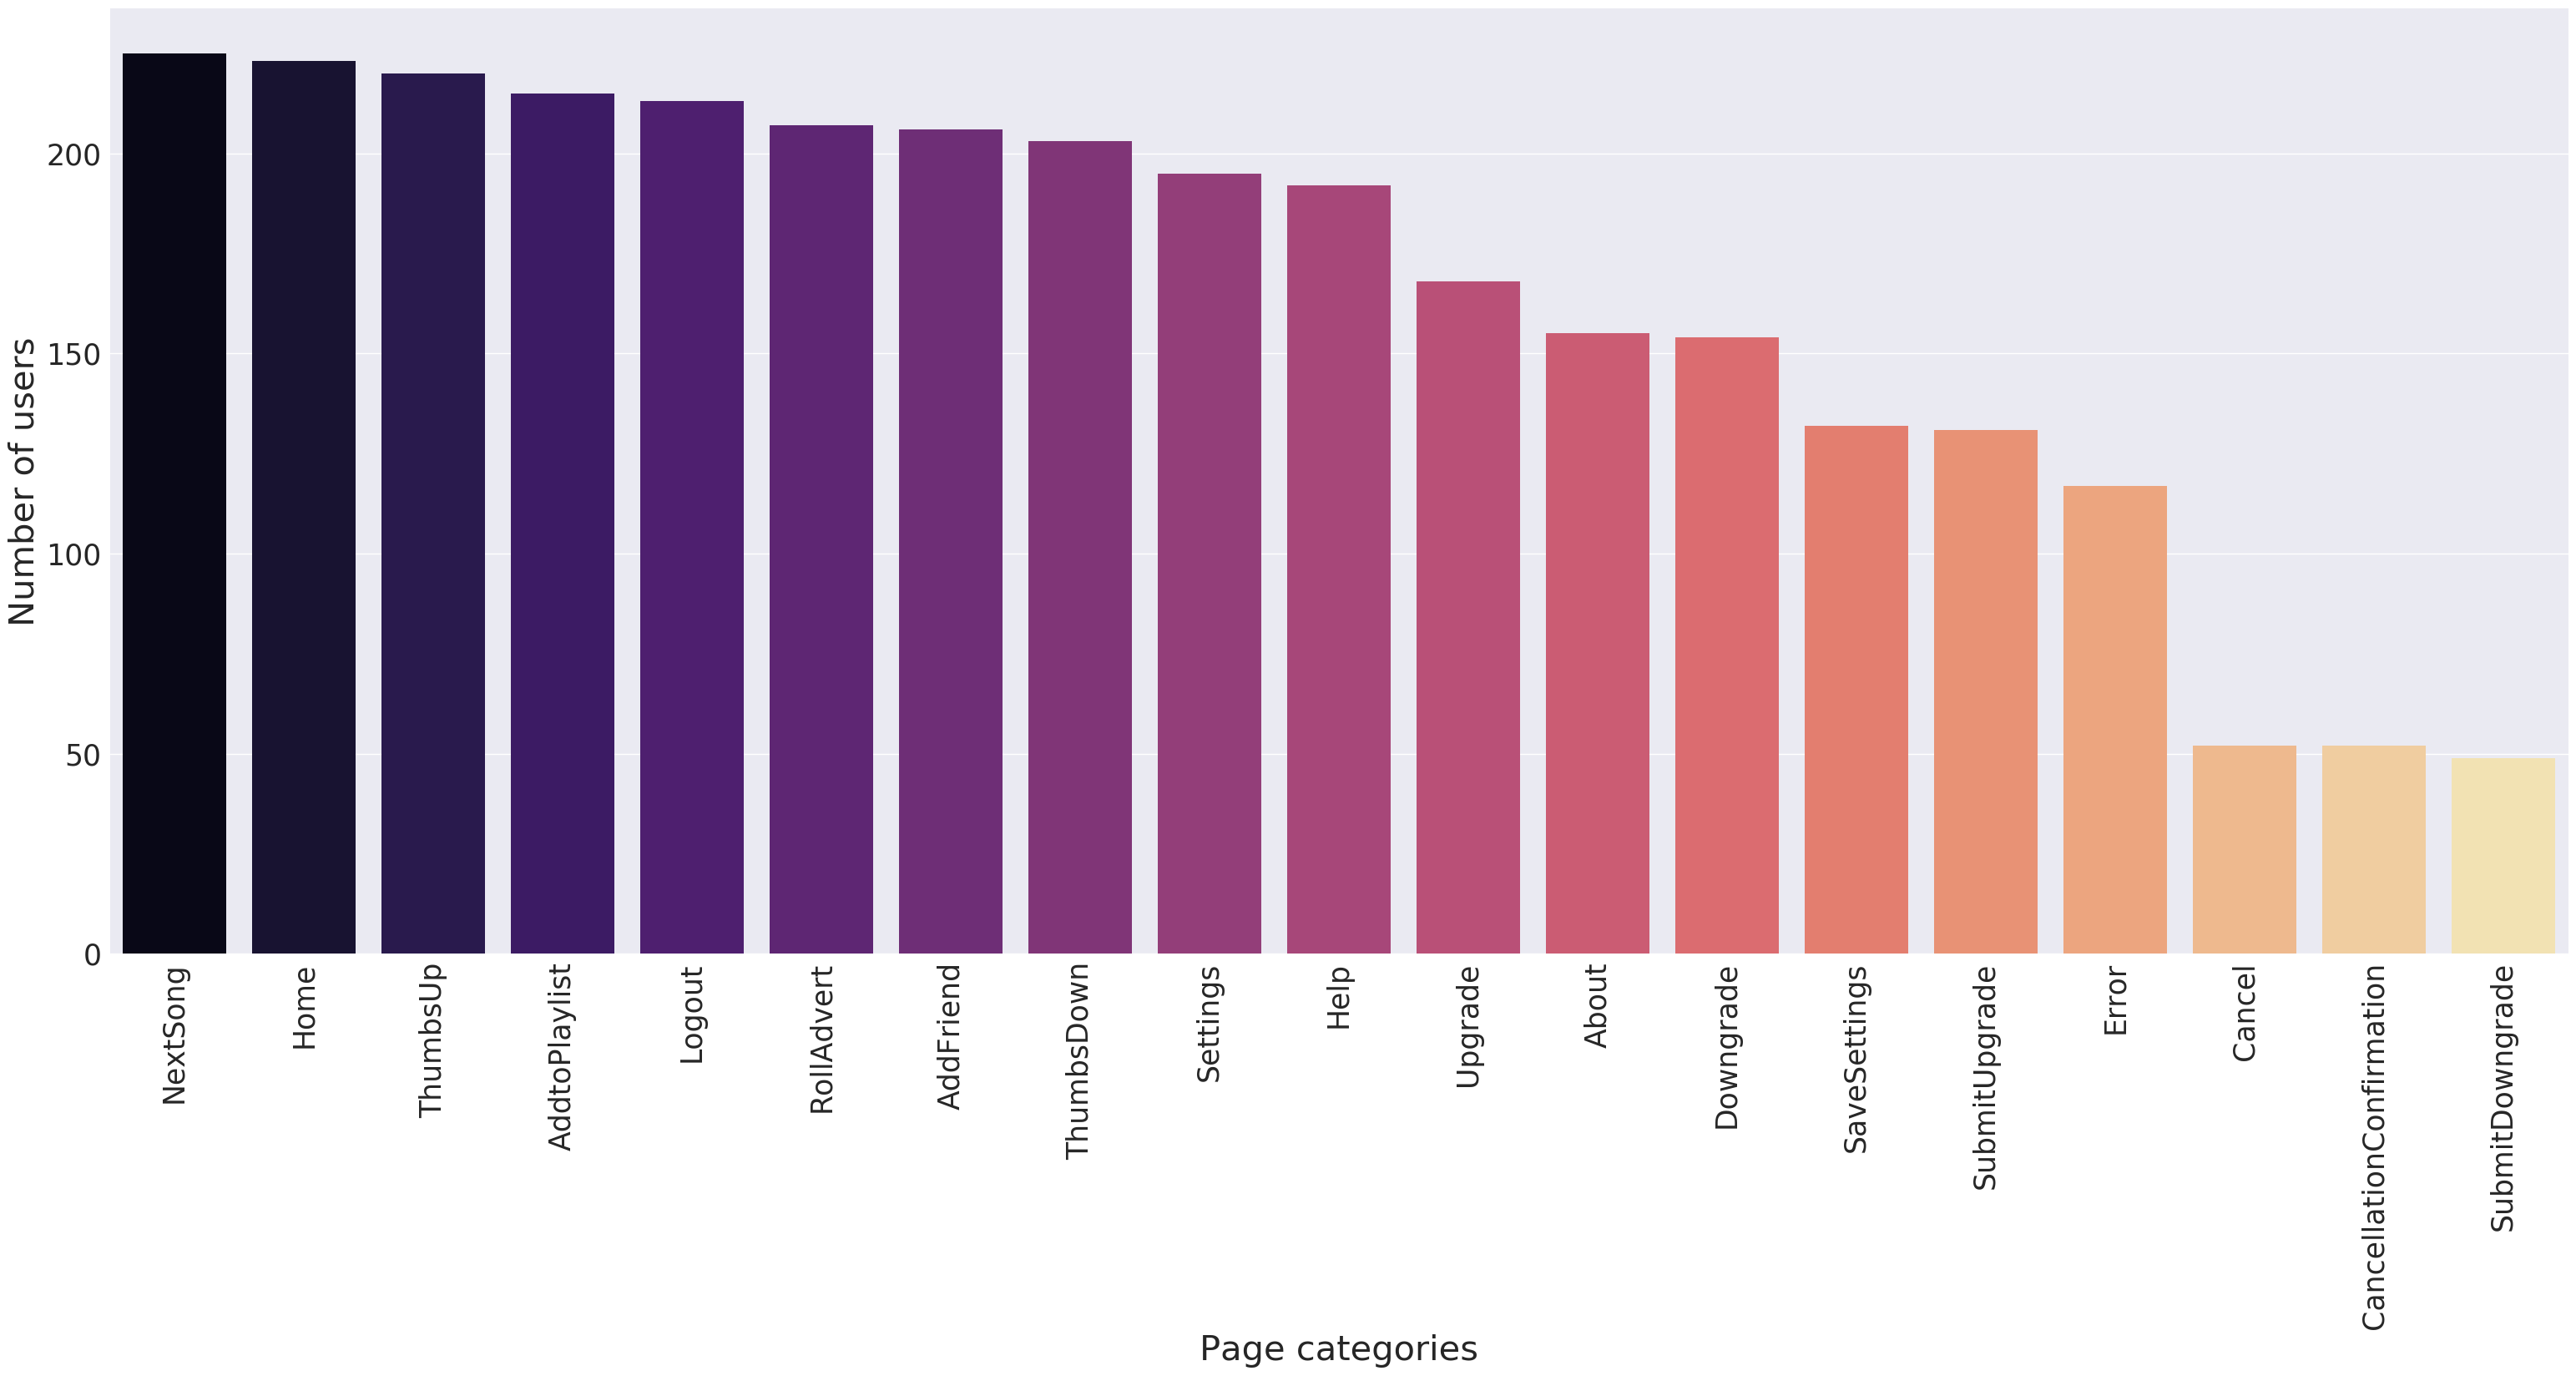

In [42]:
page_users = spark.sql('''
        SELECT page, COUNT(DISTINCT userId) AS user_freq
        FROM usersclean
        GROUP BY page
        ORDER BY user_freq DESC
''')

page_users = page_users.toPandas()

sns.set(font_scale = 2.5)
fig, ax = plt.subplots(figsize=(38,15))
ax.tick_params(axis='x', rotation=90);
pp1 = sns.barplot(x="page", y="user_freq", palette = 'magma', data=page_users, ax=ax);
pp1.set_ylabel("Number of users",fontsize=30);
pp1.set_xlabel("Page categories",fontsize=30);


In [43]:
spark.sql('''
        SELECT page, COUNT(userId) AS item_freq
        FROM usersclean
        GROUP BY page
        ORDER BY item_freq DESC
''').show()

+--------------------+---------+
|                page|item_freq|
+--------------------+---------+
|            NextSong|   228108|
|            ThumbsUp|    12551|
|                Home|    10082|
|       AddtoPlaylist|     6526|
|           AddFriend|     4277|
|          RollAdvert|     3933|
|              Logout|     3226|
|          ThumbsDown|     2546|
|           Downgrade|     2055|
|            Settings|     1514|
|                Help|     1454|
|             Upgrade|      499|
|               About|      495|
|        SaveSettings|      310|
|               Error|      252|
|       SubmitUpgrade|      159|
|     SubmitDowngrade|       63|
|              Cancel|       52|
|CancellationConfi...|       52|
+--------------------+---------+



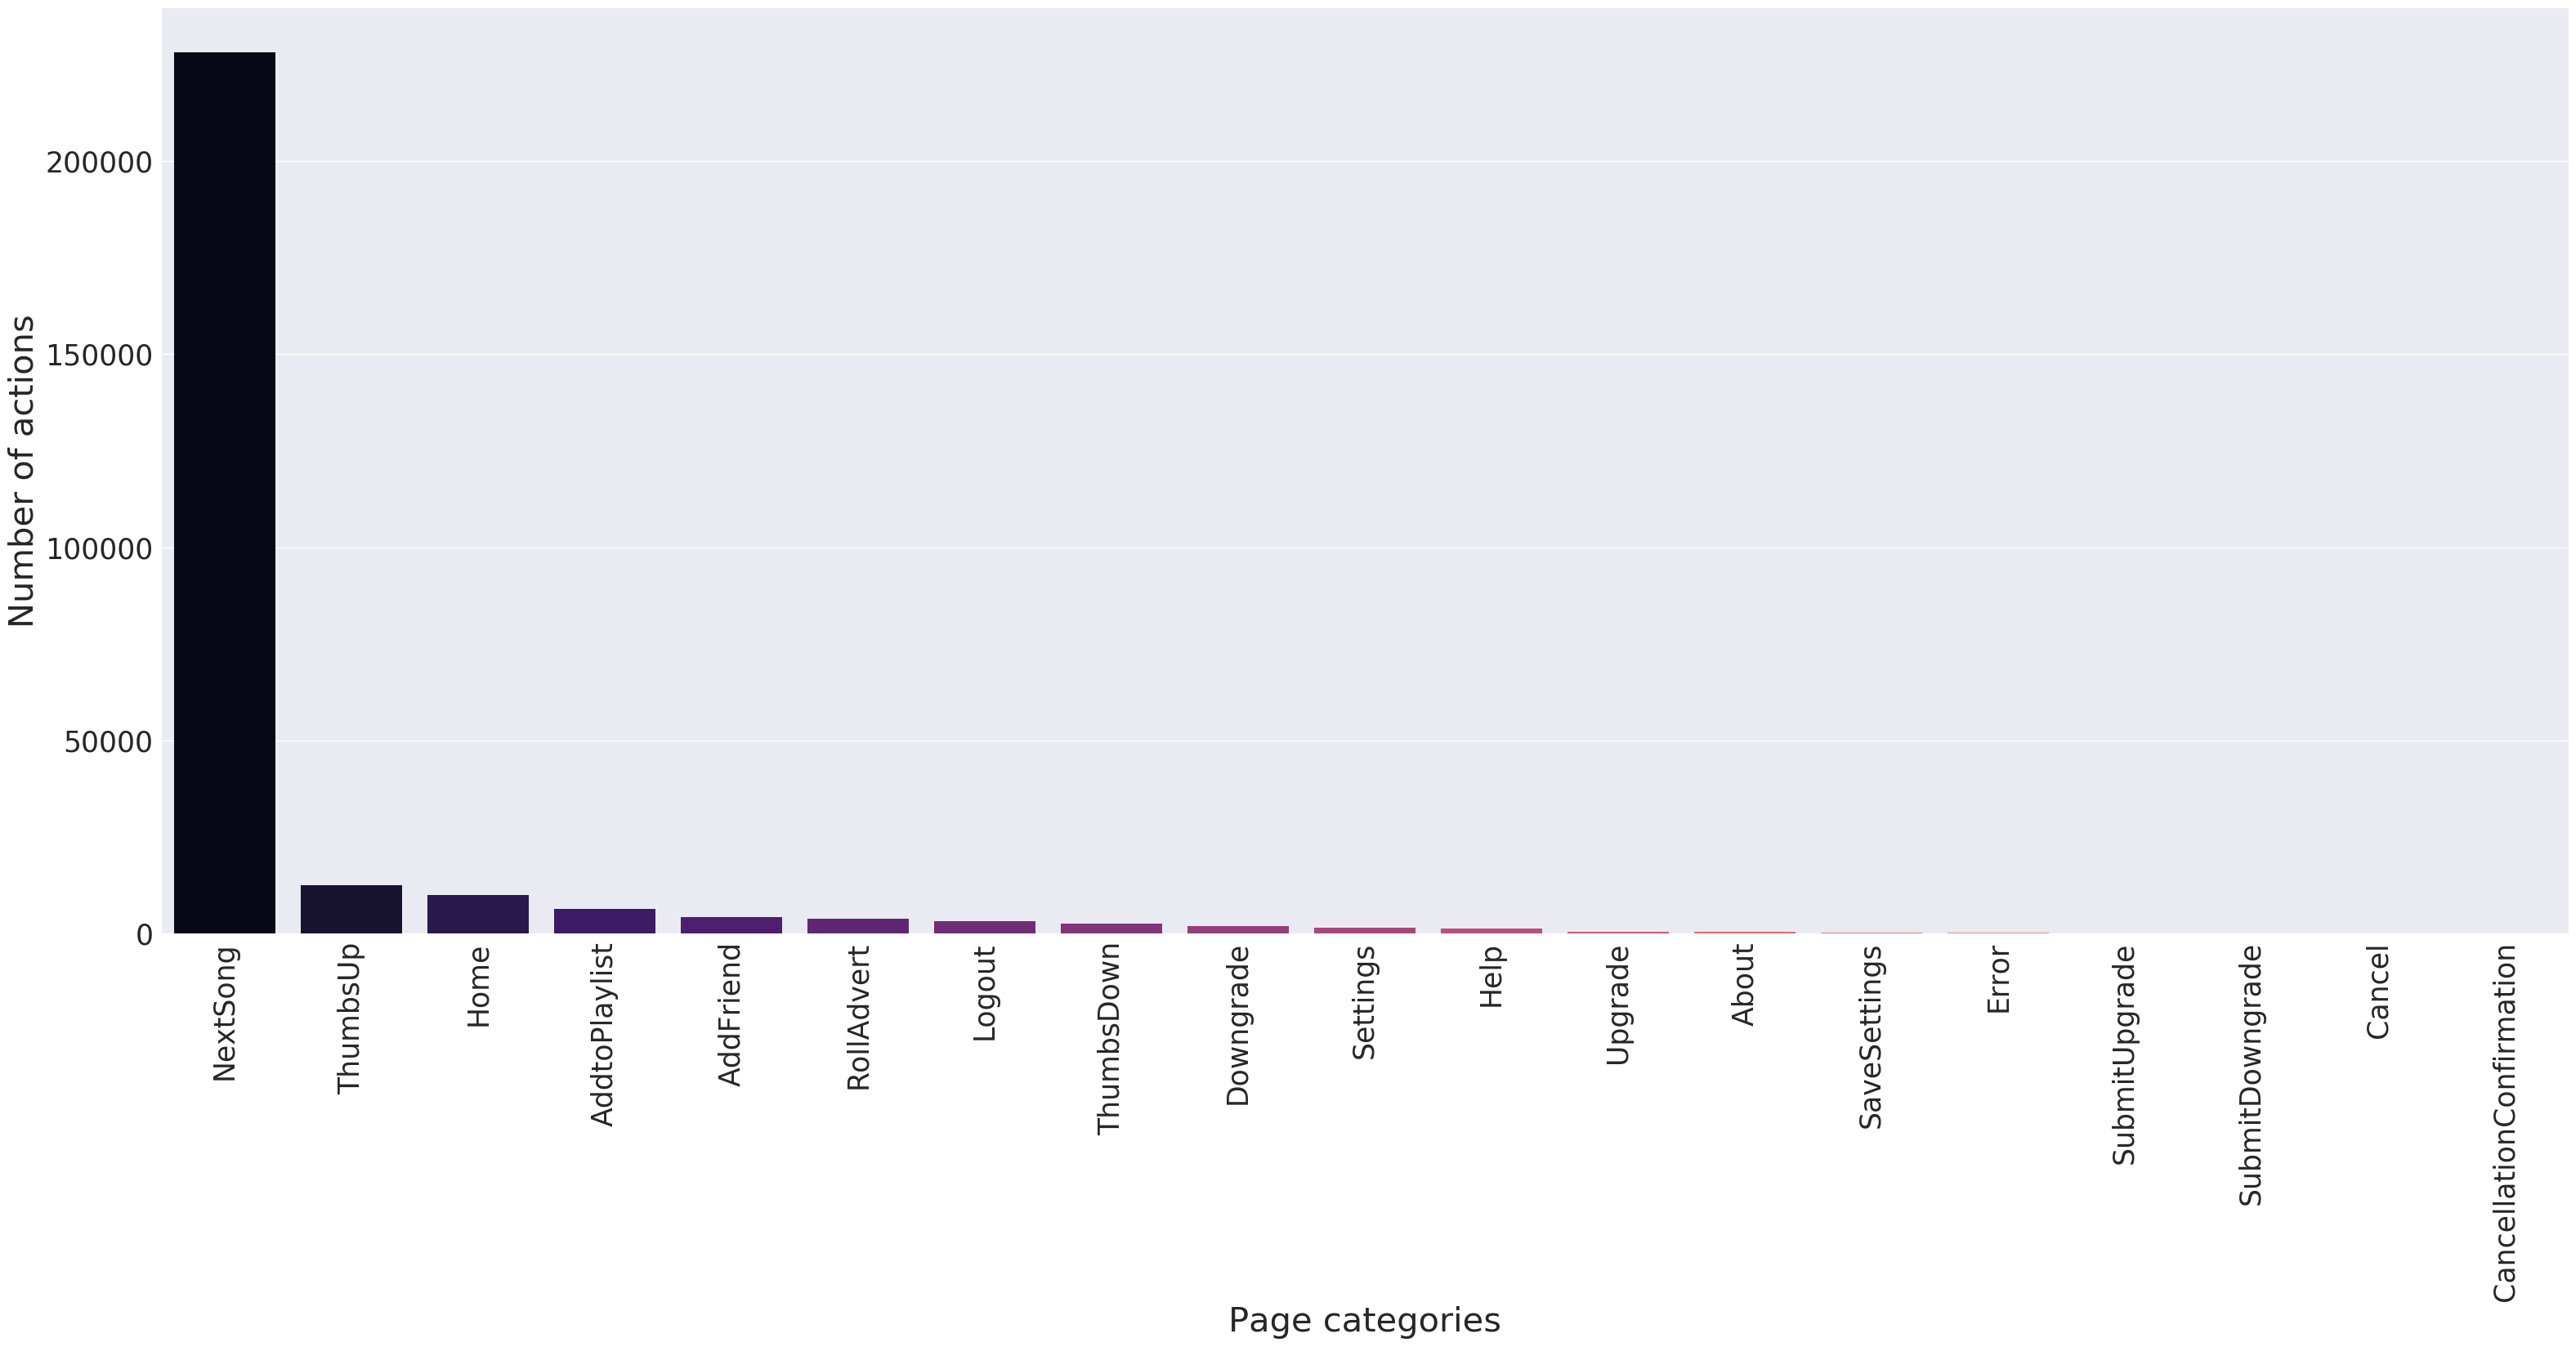

In [8]:
page_users_all = spark.sql('''
        SELECT page, COUNT( userId) AS item_freq
        FROM usersclean
        GROUP BY page
        ORDER BY item_freq DESC
''')

page_users_all = page_users_all.toPandas()

sns.set(font_scale = 2.5)
fig, ax = plt.subplots(figsize=(38,15))
ax.tick_params(axis='x', rotation=90);
pp1 = sns.barplot(x="page", y="item_freq", palette = 'magma', data=page_users_all, ax=ax);
pp1.set_ylabel("Number of actions",fontsize=30);
pp1.set_xlabel("Page categories",fontsize=30);


In [9]:
spark.sql('''
        SELECT page, COUNT(DISTINCT userId) AS user_freq
        FROM usersclean
        GROUP BY page
        ORDER BY user_freq DESC
''').show()

+--------------------+---------+
|                page|user_freq|
+--------------------+---------+
|            NextSong|      225|
|                Home|      223|
|            ThumbsUp|      220|
|       AddtoPlaylist|      215|
|              Logout|      213|
|          RollAdvert|      207|
|           AddFriend|      206|
|          ThumbsDown|      203|
|            Settings|      195|
|                Help|      192|
|             Upgrade|      168|
|               About|      155|
|           Downgrade|      154|
|        SaveSettings|      132|
|       SubmitUpgrade|      131|
|               Error|      117|
|CancellationConfi...|       52|
|              Cancel|       52|
|     SubmitDowngrade|       49|
+--------------------+---------+



In [46]:
spark.sql('''
        SELECT *
        FROM (
        SELECT userId, count(distinct page) as page_categ
        FROM usersclean
        GROUP BY userId
        )
        
''').show()

+------+----------+
|userId|page_categ|
+------+----------+
|100010|        11|
|200002|        14|
|   125|         4|
|   124|        14|
|    51|        15|
|     7|        13|
|    15|        14|
|    54|        19|
|   155|        15|
|100014|        13|
|   132|        16|
|   154|         8|
|   101|        18|
|    11|        17|
|   138|        16|
|300017|        14|
|100021|        13|
|    29|        17|
|    69|        16|
|   112|        13|
+------+----------+
only showing top 20 rows



In [47]:
# SELECT max(page_cancel),avg(page_cancel),min(page_cancel)
spark.sql('''
        SELECT count(userId)
        FROM (
        SELECT userId
        FROM usersclean
        WHERE page == "CancellationConfirmation"
        GROUP BY userId
        )
''').show()

+-------------+
|count(userId)|
+-------------+
|           52|
+-------------+



In [48]:
# SELECT max(page_cancel),avg(page_cancel),min(page_cancel)
spark.sql('''
        SELECT count(userId)
        FROM (
        SELECT userId, count(page) as page_cancel
        FROM usersclean
        WHERE (page == "CancellationConfirmation") OR (page == "Cancel")
        GROUP BY userId
        )
''').show()

+-------------+
|count(userId)|
+-------------+
|           52|
+-------------+



userId, sessionId, page

In [49]:
spark.sql('''
        SELECT  COUNT(DISTINCT userId) AS total_users
        FROM usersclean
''').show()

+-----------+
|total_users|
+-----------+
|        225|
+-----------+



In [50]:
df.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [51]:
# for a random user
spark.sql('''
        SELECT  sessionId, count( distinct level) as level, count( distinct length) as length, count( distinct itemInSession) as item 
        FROM ( SELECT *
               FROM usersclean
               WHERE userId == 30 )
        GROUP BY sessionId
''').show()

+---------+-----+------+----+
|sessionId|level|length|item|
+---------+-----+------+----+
|       29|    1|    36|  42|
|     1642|    1|     0|   1|
|     1671|    1|    32|  41|
|     2244|    2|   194| 256|
|      532|    2|   235| 290|
|      264|    1|     1|   2|
|     1632|    1|    51|  67|
|     1110|    1|    25|  31|
|     1607|    1|    20|  28|
|     1757|    1|    23|  29|
|     1786|    1|    19|  24|
|     1574|    1|    27|  35|
|      816|    1|    56|  77|
|      945|    1|     0|   1|
|      682|    1|     0|   2|
|     1812|    1|     1|   1|
|     1340|    1|    78| 106|
|     2120|    1|     7|   9|
|      614|    1|     5|   6|
|     1496|    1|    26|  31|
+---------+-----+------+----+
only showing top 20 rows



In [52]:
# for a random user and session
spark.sql('''
        SELECT  length, itemInSession, song
        FROM ( SELECT *
               FROM usersclean
               WHERE userId == 30 and sessionId == 532)
''').show()

+---------+-------------+--------------------+
|   length|itemInSession|                song|
+---------+-------------+--------------------+
|     null|            0|                null|
|351.81669|            1|          ThirdParty|
|  246.282|            2|          ItsWorking|
|197.92934|            3|IllRememberAprilD...|
|191.81669|            4|   AtmosphereStation|
| 323.5522|            5|          ThereThere|
|345.70404|            6|TilWeDieAlbumVersion|
|179.09506|            7|    LiesAlbumVersion|
|230.39955|            8|TheBalladofMichae...|
|239.90812|            9|               Gears|
|271.35955|           10|           TheseEyes|
|     null|           11|                null|
|     null|           12|                null|
|311.92771|           13|            Stronger|
|204.40771|           14|     ThisIsSuchAPity|
|239.62077|           15|Strut1993DigitalR...|
|192.67873|           16|               Fader|
|218.33098|           17|      SeQuiereSeMata|
|169.92608|  

In [53]:
spark.sql('''
        SELECT  sessionId, max(itemInSession) as max_item
        FROM usersclean
        GROUP BY userId, sessionId
''').show()

+---------+--------+
|sessionId|max_item|
+---------+--------+
|       31|      39|
|       78|       8|
|      113|      57|
|      118|      59|
|      133|      73|
|      174|     111|
|      187|      34|
|        2|       6|
|       44|      29|
|      114|      43|
|      163|     157|
|      174|     102|
|      205|     143|
|      174|      10|
|      123|     295|
|      333|     180|
|      420|     476|
|      511|       7|
|      517|     147|
|      628|      10|
+---------+--------+
only showing top 20 rows



In [54]:
spark.sql('''
        SELECT avg(max_item)
        FROM (
        SELECT max(itemInSession) as max_item
        FROM usersclean
        GROUP BY userId, sessionId
        )
        
''').show()

+-----------------+
|    avg(max_item)|
+-----------------+
|88.98110831234257|
+-----------------+



In [55]:
userAgent_sample = dfc.select("userAgent").limit(10).toPandas()

In [56]:
userAgent_sample.userAgent[0]

'Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753'

In [57]:
userAgent_sample.userAgent[1]

'Mozilla50iPhoneCPUiPhoneOS712likeMacOSXAppleWebKit537512KHTML,likeGeckoVersion70Mobile11D257Safari953753'

Very difficult to analyse the userAgent variable as every device has a different userAgent. But some browser and platforms can be detected.

---

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [10]:
def make_feature_engineering(df):

    def make_churn_var(df):
        """
        Calculates the variable of interest in order to train a machine learning classifier
        Churn or unsubscription from the service
        """
        
        df = df.withColumn('churn_action', when(col('page') ==  'CancellationConfirmation', 1).otherwise(0) )
        return df
    
    df = make_churn_var(df)
    
    # cleaning variable userAgent
    
    ##### this part of the code is modified from: https://github.com/CapAllen/Sparkify
        # get browsers
    def get_browser(x):
        """Assign a browser according to each userAgent"""
        if 'Firefox' in x:
            return 'Firefox'
        elif 'Safari' in x:
            if 'Chrome' in x:
                return 'Chrome'
            else:
                return 'Safari'
        elif 'Trident' in x:
            return 'IE'
        else:
            return np.NaN
    
    browser = udf(lambda x : get_browser(x))
    df = df.withColumn('browser', browser(df.userAgent))
    
        # get platform
    platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone', "Windows": "Windows",  
          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}
    
    #### original code again
    
    def detect_platform(x):
        """Assign a platform according to each userAgent"""
        for platform in platform_dict:
            if re.search(platform , x ) is not None:
                return platform_dict[platform]
        return "other"

    get_platform = udf(lambda x: detect_platform(x),StringType())
    df = df.withColumn('platform',get_platform(df.userAgent))
    
    # aggregating variables into users, using SQL queries
    df.createOrReplaceTempView("dfc_model")
    
    user_features = spark.sql('''
    SELECT dfc_model.userID, last_time.last_interaction, gender, platform, browser, state, level, registered_days, churn_action, nunique_artist
    FROM (
    SELECT userID, max(time) as last_interaction, count(distinct artist) as nunique_artist
    FROM dfc_model
    GROUP BY userID
    ) as last_time INNER JOIN dfc_model ON (last_time.last_interaction = dfc_model.time) AND (last_time.userId = dfc_model.userId)
    ''')
    
    user_songs_session = spark.sql('''
    SELECT userId, avg(num_songs_ses) as avg_num_songs_ses, count( distinct sessionId) as num_ses
    FROM (
    SELECT userId, sessionId, max(itemInSession) as num_songs_ses
    FROM dfc_model
    GROUP BY userId, sessionId
    ) 
    GROUP BY userId
    ''')
    
    user_page_session = spark.sql('''
    SELECT addplay.userId, avg_nextsong_ses, avg_addplay_ses
    FROM (SELECT userId, avg(num_nextsong_ses) as avg_nextsong_ses
    FROM (
    SELECT userId, sessionId, count(*) as num_nextsong_ses
    FROM dfc_model
    WHERE page = "NextSong"
    GROUP BY userId, sessionId
    ) 
    GROUP BY userId ) as nextsong
    
    INNER JOIN
    (SELECT userId, avg(num_addplay_ses) as avg_addplay_ses
    FROM (
    SELECT userId, sessionId, count(*) as num_addplay_ses
    FROM dfc_model
    WHERE page = "AddtoPlaylist"
    GROUP BY userId, sessionId
    ) 
    GROUP BY userId ) addplay on addplay.userId = nextsong.userId
    ''')
    
    df = user_features.join(user_songs_session, on='userId').join(user_page_session, on="userId")
    df = df.drop('last_interaction') 
    df = df.drop_duplicates()
    
    # rename our target variable churn_action as "label"
    df = df.withColumnRenamed('churn_action', 'label')
    
    return df 

In [11]:
features_model = make_feature_engineering(dfc)

In [73]:
features_model.printSchema()

root
 |-- userID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- state: string (nullable = true)
 |-- level: string (nullable = true)
 |-- registered_days: integer (nullable = true)
 |-- label: integer (nullable = false)
 |-- nunique_artist: long (nullable = false)
 |-- avg_num_songs_ses: double (nullable = true)
 |-- num_ses: long (nullable = false)
 |-- avg_nextsong_ses: double (nullable = true)
 |-- avg_addplay_ses: double (nullable = true)



In [ ]:
#features_model.limit(5).show()

In [12]:
features_model.createOrReplaceTempView("features_model")

In [25]:
# check that the variable is defined correctly
spark.sql('''
        SELECT count(userID)
        FROM (
        SELECT userID
        FROM features_model
        WHERE label == 1 
        GROUP BY userId
        )
''').show()

+-------------+
|count(userID)|
+-------------+
|           50|
+-------------+



In [30]:
features_model.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   50|
|    0|  165|
+-----+-----+



In [31]:
# check the variables were encoded correctly
features_model.groupBy("browser").count().show()

+-------+-----+
|browser|count|
+-------+-----+
|Firefox|   49|
| Safari|   46|
|     IE|   11|
| Chrome|  109|
+-------+-----+



In [32]:
features_model.groupBy("platform").count().show()

+--------+-----+
|platform|count|
+--------+-----+
|    iPad|    3|
|  iPhone|   13|
|   Linux|   12|
|     Mac|   81|
| Windows|  106|
+--------+-----+



In [33]:
features_model.groupBy("level").count().show()

+-----+-----+
|level|count|
+-----+-----+
| free|   71|
| paid|  144|
+-----+-----+



In [76]:
spark.sql('''
    SELECT min(diff_platform), max(diff_platform)
    FROM (
        SELECT userId, count( distinct platform ) as diff_platform
        FROM features_model
        GROUP BY  userId
        )
''').show()

+------------------+------------------+
|min(diff_platform)|max(diff_platform)|
+------------------+------------------+
|                 1|                 1|
+------------------+------------------+



In [ ]:
spark.sql('''
    SELECT min(diff_browser), max(diff_browser)
    FROM (
        SELECT userId, count( distinct browser ) as diff_browser
        FROM features_model
        GROUP BY  userId
        )
''').show()

In [ ]:
spark.sql('''
        SELECT userId, count( distinct level ) as categ_level
        FROM features_model
        GROUP BY  userId ''')

In [ ]:
#df_cleaned_cancel.dropDuplicates(['userId']).select('Churn').groupby('Churn').count().collect()

In [ ]:
#df_cleaned_cancel.select(["Churn", "length"]).groupby(["Churn"]).agg(avg('length').alias('mean_length'), 
#                                                                     stddev('length').alias('stdev_length'),
#                                                                     max('length').alias('max_length'),
#                                                                     min('length').alias('min_length')).show()

---

Variables for the model:  
**y: churn (binary), the user has cancelled the service.   
X**:
- Time pass from registration to last interaction in days
- Gender
- Level (paid or free) as % of the total time
- Location (US's state)
- Type of browser
- Type of platform
- Average of the number of songs per session per user
- Total number of sessions per user 
- Hour of the last interaction
- Average per session of selected Page categories
- Number of artists the user listen

In [13]:
# so far we are not going to use them, we should need tests with the complete dataset:
features_model = features_model.drop('state','browser','userId') 

In [11]:
features_model.printSchema()
# features_model.schema.fields 

root
 |-- gender: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- level: string (nullable = true)
 |-- registered_days: integer (nullable = true)
 |-- label: integer (nullable = false)
 |-- nunique_artist: long (nullable = false)
 |-- avg_num_songs_ses: double (nullable = true)
 |-- num_ses: long (nullable = false)
 |-- avg_nextsong_ses: double (nullable = true)
 |-- avg_addplay_ses: double (nullable = true)



In [12]:
features_model.columns

['gender',
 'platform',
 'level',
 'registered_days',
 'label',
 'nunique_artist',
 'avg_num_songs_ses',
 'num_ses',
 'avg_nextsong_ses',
 'avg_addplay_ses']

In [13]:
# visualisation as a pandas dataframe
pd_features_model = pd.DataFrame(features_model.take(10), columns= features_model.columns)
pd_features_model

,gender,platform,level,registered_days,label,nunique_artist,avg_num_songs_ses,num_ses,avg_nextsong_ses,avg_addplay_ses
0,F,iPhone,free,55,0,252,54.428571,7,39.285714,1.400000
1,M,iPhone,paid,70,0,338,80.000000,6,64.500000,1.600000
2,F,Mac,paid,131,0,2229,170.137931,29,145.678571,5.363636
3,M,Windows,paid,19,1,1385,251.900000,10,211.100000,5.777778
4,M,Windows,free,72,0,142,28.428571,7,21.428571,1.666667
5,M,Windows,paid,56,0,1302,154.866667,15,136.714286,4.214286
6,F,Windows,paid,110,1,1744,94.216216,37,81.171429,3.428571
7,F,Windows,paid,23,0,643,171.666667,6,136.666667,4.000000
8,M,Windows,paid,85,1,233,51.833333,6,42.833333,2.333333
9,F,Mac,paid,66,0,1298,147.937500,16,120.500000,3.800000


X = [3 strings, 6 numeric]. y = 1 numeric (binary)

In [14]:
cat_cols = ["gender","platform","level"]
num_cols = ["registered_days","nunique_artist","avg_num_songs_ses","num_ses","avg_nextsong_ses", "avg_addplay_ses"]

In [15]:
# This cell's code is taken from this post:
# https://towardsdatascience.com/build-an-end-to-end-machine-learning-model-with-mllib-in-pyspark-4917bdf289c5

stages = []
for categoricalCol in cat_cols:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "classVec")

    stages += [stringIndexer, encoder]
    
assemblerInputs = [c + "classVec" for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# We use the OneHotEncoderEstimator from MLlib in spark to convert each categorical feature into one-hot vectors
# next, we use VectorAssembler to combine the resulted one-hot ector and the rest of numerical features into a 
# single vector column. We append every step of the process in a stages array

In [38]:
assemblerInputs

['genderclassVec',
 'platformclassVec',
 'levelclassVec',
 'registered_days',
 'nunique_artist',
 'avg_num_songs_ses',
 'num_ses',
 'avg_nextsong_ses',
 'avg_addplay_ses']

In [16]:
# we use a pipeline to apply all the stages of transformation
# from pyspark.ml import Pipeline
cols = features_model.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(features_model)
model_data_raw = pipelineModel.transform(features_model)

# select the columns we want
#selectedCols = ['features']+ cols
#features_model_transf = features_model_transf.select(selectedCols)
#pd.DataFrame(features_model_transf.take(5), columns=features_model_transf.columns)

In [17]:
model_data = model_data_raw.select("label","features")

In [54]:
model_data.columns

['label', 'features']

In [53]:
pd_model_data = pd.DataFrame(model_data.take(10), columns= model_data.columns)
pd_model_data

,label,features
0,0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 55.0, 252.0, 54..."
1,0,"[1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 70.0, 338.0, 80..."
2,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 131.0, 2229.0, ..."
3,1,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 19.0, 1385.0, 2..."
4,0,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 72.0, 142.0, 28..."
5,0,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 56.0, 1302.0, 1..."
6,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 110.0, 1744.0, ..."
7,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 23.0, 643.0, 17..."
8,1,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 85.0, 233.0, 51..."
9,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 66.0, 1298.0, 1..."


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

FIRST training with logistic regression

In [18]:
# Split the data into train and test subsets
train, test = model_data.randomSplit([0.8, 0.2], seed=1997)

In [31]:
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=15)
LR_model = LR.fit(train)

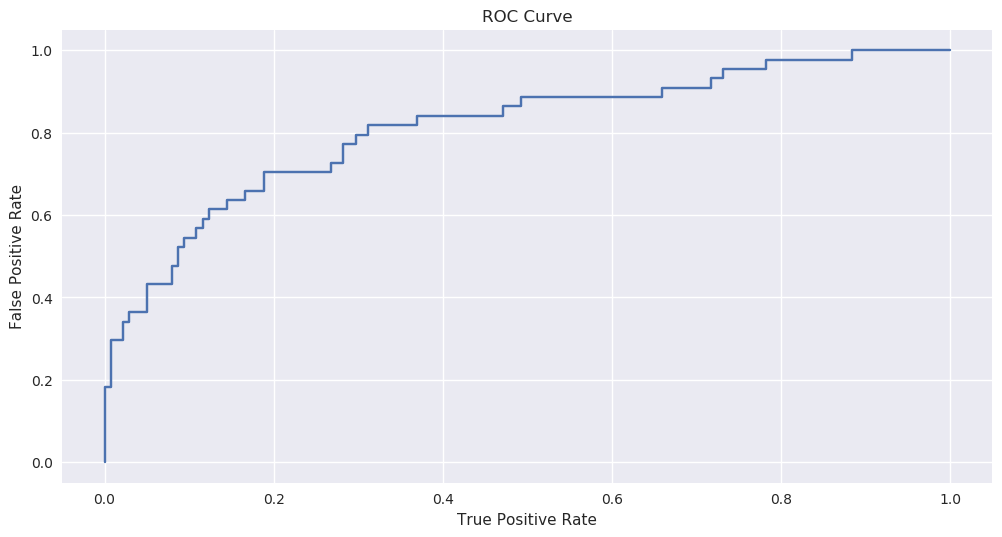

Training set ROC: 0.8119235836627142


In [32]:
trainingSummary = LR_model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [43]:
print("Coefficients: " + str(LR_model.coefficients)) 
print("Intercept: " + str(LR_model.intercept))

Coefficients: [0.165523667512,2.26810762694,2.33015495823,2.94206975211,2.36120177807,0.54983381911,-0.0427499132421,5.84681764818e-05,-0.000137675884009,-0.017294721775,-0.00931275184841,-0.011618786295]
Intercept: -0.04354048423702415


In [47]:
[np.round(num, 4) for num in LR_model.coefficients]

[0.16550000000000001,
 2.2681,
 2.3302,
 2.9420999999999999,
 2.3612000000000002,
 0.54979999999999996,
 -0.042700000000000002,
 0.0001,
 -0.0001,
 -0.017299999999999999,
 -0.0092999999999999992,
 -0.011599999999999999]

In [39]:
# Variables of the coefficients:
# 1 for gender, 4 for platform, 1 for level, 1 for each numeric
assemblerInputs

['genderclassVec',
 'platformclassVec',
 'levelclassVec',
 'registered_days',
 'nunique_artist',
 'avg_num_songs_ses',
 'num_ses',
 'avg_nextsong_ses',
 'avg_addplay_ses']

---

In [19]:
def fit_predict(train, test, model):
    """
    Fits and runs predictions with given training and test data
    Displays results for given model through function evaluate_model
    model: name of the model as a string
    """
    start = time.time() 

    if model == 'logistic_regression':
        ml = LogisticRegression(maxIter=20)
    elif model == 'random_forest':
        ml = RandomForestClassifier(seed=1997)
    elif model == 'gradient_boosting':
        ml = GBTClassifier(seed=1997)
    elif model == 'support_vector_class':
        ml = LinearSVC()
    else:
        return "Model introduced incorrectly"
    
    # Fit and calculate predictions
    clf = ml.fit(train)
    results = clf.transform(test)

    evaluate_model(results, model)
    
    end = time.time() 
    pred_time = (end-start)/60
    print("Minutes to train the model: {:.2f}".format(pred_time) )
    
    return clf, results # not used

...

In [20]:
def evaluate_model(results,model):
    """
    Runs output evaluator on the prediction results
    """

    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
    
    accuracy_score_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy_score = accuracy_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
    print('The F1 score for the', model, 'on the test set is {:.2%}'.format(f1_score)) 
    print('The accuracy score for the', model, 'on the test set is {:.2%}'.format(accuracy_score)) 
    
    auc_evaluator = BinaryClassificationEvaluator()
    metric_value = auc_evaluator.evaluate(results, {auc_evaluator.metricName: "areaUnderROC"})
    print('The areaUnderROC for the', model, ' on the test set is {:.2%}'.format(metric_value))

In [37]:
# Fit various models and visualize their evaluation metrics
for model in ['logistic_regression', 'random_forest', 'gradient_boosting']:
    fit_predict(train, test, model)

The F1 score for the logistic_regression on the test set is 80.32%
The accuracy score for the logistic_regression on the test set is 81.82%
The areaUnderROC for the logistic_regression  on the test set is 62.96%
Minutes to train the model: 8.45
The F1 score for the random_forest on the test set is 78.02%
The accuracy score for the random_forest on the test set is 78.79%
The areaUnderROC for the random_forest  on the test set is 55.56%
Minutes to train the model: 6.37
The F1 score for the gradient_boosting on the test set is 75.76%
The accuracy score for the gradient_boosting on the test set is 75.76%
The areaUnderROC for the gradient_boosting  on the test set is 55.56%
Minutes to train the model: 10.40


---

Hyperparameter tuning:

In [21]:
def tune_rf(train, test, numTrees=[20,40], maxDepth=[4,8]):
    """
    Tunes numTrees and maxDepth parameters for random forest classifier
    Runs gridsearch, evaluates the results and prints best parameters
    """
    clf = RandomForestClassifier(seed=1997)
    
    paramGrid = ParamGridBuilder() \
        .addGrid(clf.numTrees, numTrees) \
        .addGrid(clf.maxDepth, maxDepth) \
        .build()   
    
    crossval = CrossValidator(estimator = Pipeline(stages=[clf]),
                         estimatorParamMaps = paramGrid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 2)

    cvModel = crossval.fit(train)
    predictions = cvModel.transform(test)
    
    evaluate_model(predictions, "RF")
    
    bestPipeline = cvModel.bestModel

    return bestPipeline


In [22]:
results_tuning = tune_rf(train, test)

The F1 score for the RF on the test set is 73.77%
The accuracy score for the RF on the test set is 75.76%
The areaUnderROC for the RF  on the test set is 54.94%


In [25]:
results_tuning.stages[0].featureImportances

SparseVector(12, {0: 0.027, 1: 0.0171, 2: 0.022, 3: 0.0068, 4: 0.0077, 5: 0.0204, 6: 0.336, 7: 0.1359, 8: 0.097, 9: 0.131, 10: 0.1002, 11: 0.0989})

In [27]:
features_model.columns
#It's important to take into account that the categorical variables have multiple columns (hot encoding)

['gender',
 'platform',
 'level',
 'registered_days',
 'label',
 'nunique_artist',
 'avg_num_songs_ses',
 'num_ses',
 'avg_nextsong_ses',
 'avg_addplay_ses']

In [41]:
encoded_variables = ["gender","platform1","platform2","platform3","platform4","level"] + num_cols

In [43]:
# prints feature importances
for i in range(len(encoded_variables)):
    print("{} : {} \n".format(encoded_variables[i], results_tuning.stages[0].featureImportances[i]))

gender : 0.02699034190233457 

platform1 : 0.01710668298293331 

platform2 : 0.021976519530360738 

platform3 : 0.006775586316735651 

platform4 : 0.007720388026172817 

level : 0.02039378414581674 

registered_days : 0.3360377327216369 

nunique_artist : 0.13591180448401824 

avg_num_songs_ses : 0.0969707814865977 

num_ses : 0.13096341518453353 

avg_nextsong_ses : 0.10024919581271366 

avg_addplay_ses : 0.09890376740614606 



In [44]:
# prints feature importances
for i in range(len(results_tuning.stages[0].featureImportances)):
    print("{} : {} \n".format(encoded_variables[i], results_tuning.stages[0].featureImportances[i]))

print('Best parameters : max depth:{}, num Trees:{}'.\
    format(results_tuning.stages[0].getOrDefault('maxDepth'), results_tuning.stages[0].getNumTrees))

gender : 0.02699034190233457 

platform1 : 0.01710668298293331 

platform2 : 0.021976519530360738 

platform3 : 0.006775586316735651 

platform4 : 0.007720388026172817 

level : 0.02039378414581674 

registered_days : 0.3360377327216369 

nunique_artist : 0.13591180448401824 

avg_num_songs_ses : 0.0969707814865977 

num_ses : 0.13096341518453353 

avg_nextsong_ses : 0.10024919581271366 

avg_addplay_ses : 0.09890376740614606 

Best parameters : max depth:8, num Trees:40


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

Done